# Test criterions for Benchmark

In [74]:
# FUNCTIONS / CLASSES :
import sys
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
sys.path.append("./code")
from metrics import *
from criterions import compute_correlation, domain_coverage, bad_quality_detection, Borda_count

## DICTIONNAIRE DES COUPLES DE TRADUCTIONS :
sl_tls = {
    "ende" : "English-German",
    "enru" : "English-Russian",
    "zhen" : "Chinese-English" 
}

# Fast metrics :
metrics = { "ngram_based" :[BLEU,
           Sacre_BLEU,
           ROUGE_1,
           ROUGE_L,
           ROUGE_S4,
           CHRF,
           CHRF_1,
           CHRF_pp,
           METEOR],
           
           "edit_based": [WER, TER]}

# Energivore metrics :   
metrics_embd =[BARY,
            DEPTH,
            MOVER]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
data = pd.read_csv("./data/ngram_based_metrics_scores.csv")

In [8]:
compute_correlation(
    data = data,
    metric_1 = str(metrics_ngram[1].__name__),
    metric_2 = str(metrics_ngram[2].__name__),
    correlation_type = "spearman"
)

0.462788019552205

In [10]:
data = pd.read_csv("./data/ngram_based_metrics_scores.csv")
data = data[data.sltl == "ende"]

print("Correlation w human score : ")
for metric in metrics_ngram:
    metric_name = str(metric.__name__)
    print("METRIC NAME : ", metric_name)
    for domain in data.domain.unique():
        score = domain_coverage(
                    data = data,
                    candidate_metric = metric_name,
                    correlation_type = "spearman",
                    domain = domain
                )
        print(domain.upper(), " => ", score)
    
    print("\n")

Correlation w human score : 
METRIC NAME :  BLEU
CONVERSATION  =>  0.2690547729282605
NEWS  =>  0.13753846033647954
ECOMMERCE  =>  0.1474266728613931
SOCIAL  =>  0.13686813474759743


METRIC NAME :  Sacre_BLEU
CONVERSATION  =>  0.2819671864070406
NEWS  =>  0.14931235789144323
ECOMMERCE  =>  0.14481209574501688
SOCIAL  =>  0.1344726369374118


METRIC NAME :  ROUGE_1
CONVERSATION  =>  0.28209454603980927
NEWS  =>  0.15131629222771703
ECOMMERCE  =>  0.12887179360163514
SOCIAL  =>  0.1312618640006047


METRIC NAME :  ROUGE_L
CONVERSATION  =>  0.27891270535136975
NEWS  =>  0.15080596371074756
ECOMMERCE  =>  0.12682009610544911
SOCIAL  =>  0.13071684213111492


METRIC NAME :  ROUGE_S4
CONVERSATION  =>  0.26746331278737673
NEWS  =>  0.14012899578376467
ECOMMERCE  =>  0.13684461071665172
SOCIAL  =>  0.106343673914925


METRIC NAME :  CHRF
CONVERSATION  =>  0.32104288615842846
NEWS  =>  0.16161813593835653
ECOMMERCE  =>  0.12404545301405787
SOCIAL  =>  0.14901331381144958


METRIC NAME :  CHRF_

In [12]:
data = pd.read_csv("./data/ngram_based_metrics_scores.csv")
data = data[data.sltl == "ende"]

print("Correlation w human score : ")
for metric in metrics_ngram:
    metric_name = str(metric.__name__)
    print("METRIC NAME : ", metric_name)
    score = bad_quality_detection(
                data = data,
                candidate_metric = metric_name,
                correlation_type = "spearman",
                alpha = 0.1
            )
    print("SCORE => ", score)
    print("\n")

Correlation w human score : 
METRIC NAME :  BLEU
SCORE =>  0.12923011554030808


METRIC NAME :  Sacre_BLEU
SCORE =>  0.1478535900937936


METRIC NAME :  ROUGE_1
SCORE =>  0.14261265151348962


METRIC NAME :  ROUGE_L
SCORE =>  0.14324826704846574


METRIC NAME :  ROUGE_S4
SCORE =>  0.13726613949226157


METRIC NAME :  CHRF
SCORE =>  0.14354626182454208


METRIC NAME :  CHRF_1
SCORE =>  0.1486626282468477


METRIC NAME :  CHRF_pp
SCORE =>  0.14524505771968801


METRIC NAME :  METEOR
SCORE =>  0.14359880414191742




In [60]:
for index, metric_type in enumerate(metrics):
    temp = pd.read_csv("./data/" + metric_type + "_metrics_scores.csv")
    
    if index == 0:
        data = temp.copy()
    else:
        temp = temp[[str(metric.__name__) for metric in metrics[metric_type]]]
        data = data.merge(temp, left_index=True, right_index=True)

[[ 5.  6.  7.  1.  8.  0. 10.  9.  4.  2.  3.]
 [ 8.  6.  5.  7. 10.  9.  1.  4.  0.  2.  3.]
 [ 7.  5.  6.  8.  1. 10.  9.  0.  4.  3.  2.]
 [ 8.  7.  6.  5.  2.  3.  1.  0. 10.  4.  9.]
 [ 8. 10.  9.  3.  1.  2.  6.  7.  4.  5.  0.]
 [ 6.  4.  7.  8.  5. 10.  1.  9.  0.  3.  2.]]
BORDA COUNT RANKS : 


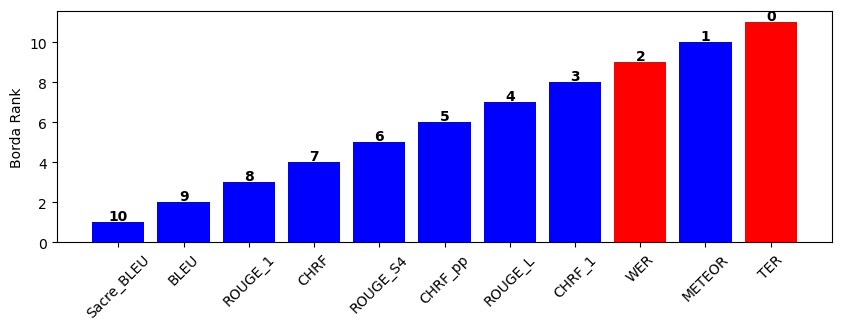

In [72]:
metrics_all = [metric for sublist in metrics.values() for metric in sublist]

for key, val in sl_tls.items():
    print(key)
    print(val)
    
    query = data[data.sltl == sl_tls]
    
    borda_count_ranks = Borda_count(
                            data = data,
                            metrics = metrics_all,
                            correlation_type = "spearman"
                        )

    print("BORDA COUNT RANKS : ")
    plt.figure(figsize = (10, 3))

    category_colors = {
        "ngram_based": "blue",
        "edit_based": "red"
    }

    metrics_ranks = {}
    for n in range(len(metrics_all)):
        category = "ngram_based" if metrics_all[n] in metrics["ngram_based"] else "edit_based"
        metrics_ranks[str(metrics_all[n].__name__)] = (borda_count_ranks[n], category)

    sorted_scores = sorted(metrics_ranks.items(), key=lambda x: x[1][0], reverse=True)

    x = [sorted_scores[k][0] for k in range(len(metrics_all))]
    y = [len(metrics_all) - sorted_scores[k][1][0] for k in range(len(metrics_all))]
    colors = [category_colors[sorted_scores[k][1][1]] for k in range(len(metrics_all))]

    plt.bar(x, y, color=colors)

    for i, v in enumerate(sorted_scores):
        plt.text(i, y[i] + 0.1, str(v[1][0]), ha='center', fontweight='bold')

    plt.ylabel('Borda Rank')
    plt.xticks(rotation=45)
    plt.show()


BORDA COUNT RANKS : 
METEOR  :  0
BLEU  :  1
NIST  :  2
WACC  :  3


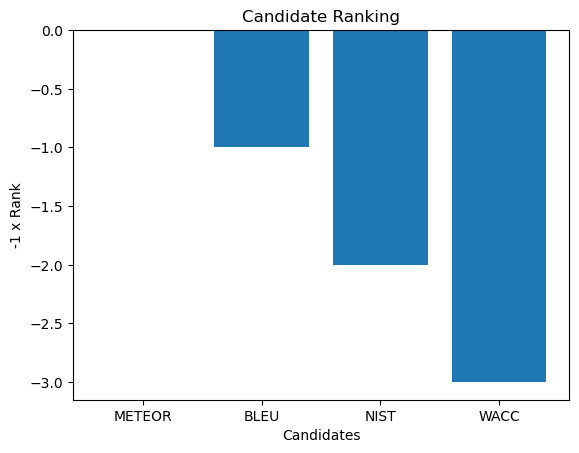

In [8]:
data = pd.read_csv("./data/metrics_scores.csv")
L = len(data.domain.unique())
N = len(metrics)
ranks = np.empty((L, N))

for l in range(L):
    criterion_scores = []
    criterion_domain = data.domain.unique()[l]
    for n in range(N):
        candidate_metric = str(metrics[n].__name__)
        score = domain_coverage(
                    data = data,
                    candidate_metric = candidate_metric,
                    correlation_type = "spearman",
                    domain = criterion_domain
                )
        criterion_scores.append(-1*score)
    
    ranks[l,:] = np.argsort(criterion_scores)

borda_count_ranks = Borda_count(ranks)
